This notebook was made to create buoyancy frequency N2 by using realistic model results for project need.

In [1]:
import netCDF4 as nc
import numpy as np

from salishsea_tools.nowcast import analyze
import matplotlib.pyplot as plt 
import datetime
from salishsea_tools.nowcast import figures
%matplotlib inline

In [2]:
def calculate_density(t, s):
    """Caluclates the density given temperature in deg C (t)
    and salinity in psu (s).

    returns the density as an array (rho)
    """

    rho = (
        999.842594 + 6.793952e-2 * t
        - 9.095290e-3 * t*t + 1.001685e-4 * t*t*t
        - 1.120083e-6 * t*t*t*t + 6.536332e-9 * t*t*t*t*t
        + 8.24493e-1 * s - 4.0899e-3 * t*s
        + 7.6438e-5 * t*t*s - 8.2467e-7 * t*t*t*s
        + 5.3875e-9 * t*t*t*t*s - 5.72466e-3 * s**1.5
        + 1.0227e-4 * t*s**1.5 - 1.6546e-6 * t*t*s**1.5
        + 4.8314e-4 * s*s
        )

    return rho

In [3]:
def calculate_buoyancy_frequency(temp, sal, e3, depth_axis=1):
    """ Calculate the squared buoyancy frequency (n2) given temperature and
    salinity profiles. N2 is set to  g*drho/dz/rho. Note that NEMO uses a 
    defintion based on an equation of state:   
    g* (alpha dk[T] + beta dk[S] ) / e3w

    temp and sal are the temperature and salinity arrays
    e3 is an array of the vertical scale factors (grid spacing). Use e3w for
    constistency with NEMO.
    depth_axis defines the axis which corresponds to depth in the temp/sal
    arrays

    returns n2, an array of square buoyancy frequency at each point in temp/sal.
    """

    # acceleration due to gravity
    g = 9.80665

    # First calculate density.
    rho = calculate_density(temp, sal)

    # Density gradient
    drho = np.zeros(rho.shape)
    # roll depth axis in rho and drho to first axis
    # assume e3 already has depth axis in first axis
    drho_r = np.rollaxis(drho, depth_axis)
    rho_r = np.rollaxis(rho, depth_axis)
    for k in np.arange(1, drho.shape[depth_axis]-1):
        drho_r[k, ...] = 1/e3[k, ...]*(rho_r[k+1, ...] - rho_r[k, ...])
    # Unroll drho
    drho = np.rollaxis(drho_r, 0, depth_axis+1)
    rho = np.rollaxis(rho_r, 0, depth_axis+1)
    # Define N2
    n2 = g*drho/rho  # no negative because depth increases with increasking k

    return n2

# summer stratification

In [4]:
to = datetime.datetime(2015, 5, 1)
tf = datetime.datetime(2015, 6, 30)

In [5]:
jmin = 379
jmax = 497
imin = 236
imax = 321
jss = np.arange(jmin, jmax)
iss = np.arange(imin, imax)
ks = np.arange(0,40)

files = analyze.get_filenames(to, tf, '1d', 'grid_T', '/results/SalishSea/nowcast/')

sal, times =  analyze.combine_files(files, 'vosaline',ks, jss, iss)
temp, times =  analyze.combine_files(files, 'votemper',ks, jss, iss)

/ocean/jieliu/research/meopar/tools/SalishSeaTools/salishsea_tools/nowcast/analyze.py:169: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kss == 'None':


In [6]:
rho = calculate_density(temp, sal)
rho = np.ma.masked_less(rho, 0)
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
e3w = mesh.variables['e3w'][0,:,jss,iss]
n2 = calculate_buoyancy_frequency(temp, sal, e3w)
n2 = np.ma.masked_less(n2, 0)
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
e3w = mesh.variables['e3w'][0,:,jss,iss]
n2 = calculate_buoyancy_frequency(temp, sal, e3w)
n2 = np.ma.masked_less(n2, 0)

In [7]:
lons= mesh.variables['glamt'][0,jss,iss]
lats = mesh.variables['gphit'][0,jss,iss]
depths = mesh.variables['gdept'][0,:,jss,iss]

Look at point at (496,238)

In [8]:
jps = {}; ips ={}
name ='First Point'
jps[name]=496
ips[name]=238

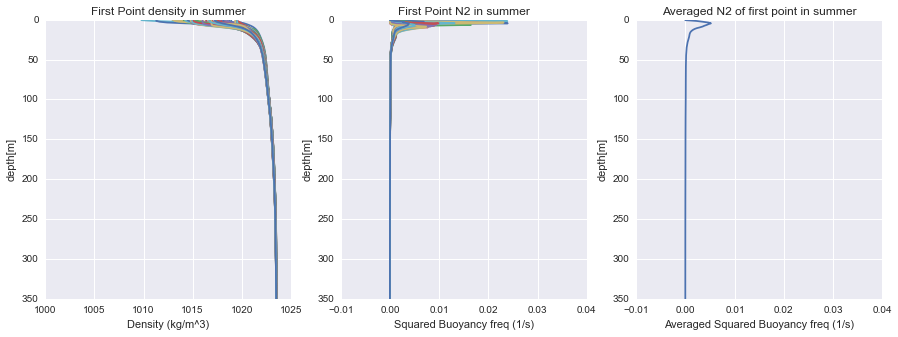

In [9]:
import seaborn as sns
sns.set_style('darkgrid')
fig,axs = plt.subplots(1,3,figsize=(15,5))
for t in np.arange(rho.shape[0]):
    axs[0].plot( rho[t,:,jps[name]-379,ips[name]-236], depths[:,jps[name]-379,ips[name]-236])
    axs[1].plot(n2[t,:,jps[name]-379,ips[name]-236], depths[:,jps[name]-379,ips[name]-236])
ax=axs[0]
ax.set_title('{} density'.format(name)+' in summer')
ax.set_xlim([1000,1025])
ax.set_ylim([350, 0])
ax.set_xlabel('Density (kg/m^3)')
ax.set_ylabel('depth[m]')
ax=axs[1]
ax.set_title('{} N2'.format(name)+' in summer')
ax.set_xlim([-.01, 0.04])
ax.set_ylim([ 350, 0])
ax.set_xlabel('Squared Buoyancy freq (1/s)')
ax.set_ylabel('depth[m]')
ax=axs[2]
n2_ave = np.mean(n2, axis = 0)
final_n2 = n2_ave[:,jps[name]-379,ips[name]-236]
ax.plot(final_n2, depths[:,jps[name]-379,ips[name]-236])
ax.set_xlim([-.01, 0.04])
ax.set_ylim([ 350, 0])
ax.set_xlabel('Averaged Squared Buoyancy freq (1/s)')
ax.set_ylabel('depth[m]')
ax.set_title('Averaged N2 of first point in summer')

# winter stratification

In [54]:
to = datetime.datetime(2014, 10, 1)
tf = datetime.datetime(2014, 12, 31)

In [55]:
files = analyze.get_filenames(to, tf, '1d', 'grid_T', '/results/SalishSea/nowcast/')

sal, times =  analyze.combine_files(files, 'vosaline',ks, jss, iss)
temp, times =  analyze.combine_files(files, 'votemper',ks, jss, iss)

/ocean/jieliu/research/meopar/tools/SalishSeaTools/salishsea_tools/nowcast/analyze.py:169: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kss == 'None':


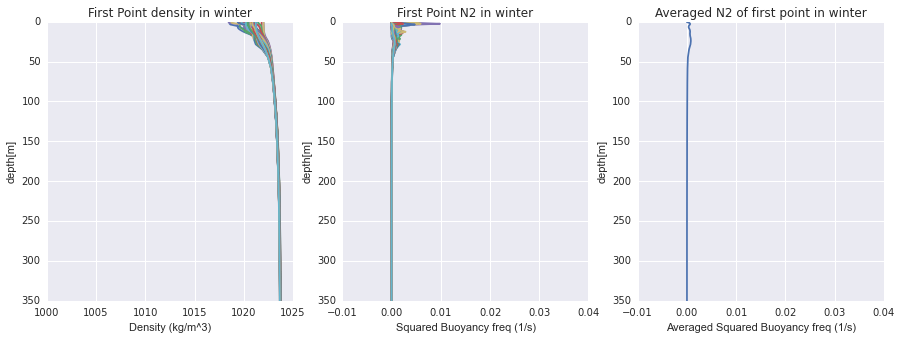

In [62]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for t in np.arange(rho.shape[0]):
    axs[0].plot( rho[t,:,jps[name]-379,ips[name]-236], depths[:,jps[name]-379,ips[name]-236])
    axs[1].plot(n2[t,:,jps[name]-379,ips[name]-236], depths[:,jps[name]-379,ips[name]-236])
ax=axs[0]
ax.set_title('{} density'.format(name)+' in winter')
ax.set_xlim([1000,1025])
ax.set_ylim([350, 0])
ax.set_xlabel('Density (kg/m^3)')
ax.set_ylabel('depth[m]')
ax=axs[1]
ax.set_title('{} N2'.format(name)+' in winter')
ax.set_xlim([-.01, 0.04])
ax.set_ylim([ 350, 0])
ax.set_xlabel('Squared Buoyancy freq (1/s)')
ax.set_ylabel('depth[m]')
ax=axs[2]
n2_ave = np.mean(n2, axis = 0)
final_n2 = n2_ave[:,jps[name]-379,ips[name]-236]
ax.plot(final_n2, depths[:,jps[name]-379,ips[name]-236])
ax.set_xlim([-.01, 0.04])
ax.set_ylim([ 350, 0])
ax.set_xlabel('Averaged Squared Buoyancy freq (1/s)')
ax.set_ylabel('depth[m]')
ax.set_title('Averaged N2 of first point in winter')

In [64]:
depths.shape

(40, 118, 85)